## **Latihan Ensemble Model Boosting**

### **Gunakan dataset churn**

**Buatlah machine learning model yang dapat memprediksi siapa saja customers yang akan meninggalkan bank!**

- Tujuannya adalah menentukan apakah seorang customer akan melakukan churn (tidak menggunakan jasa lagi) dari bank ini.

**Dataset overview:**
- It consists of 10000 observations and 12 variables.
- Independent variables contain information about customers.
- Dependent variable refers to customer abandonment.

**Features:**
- Surname: Surname
- CreditScore: Credit score
- Geography: Country (Germany/ France/ Spain)
- Gender: Gender (Female/ Male)
- Age: Age
- Tenure: How many years of customer
- Balance: Balance
- NumOfProducts: The number of bank product used
- HasCrCard: Credit card status (0 = No, 1 = Yes)
- IsActiveMember: Active membership status (0 = No, 1 = Yes)
- EstimatedSalary: Estimated salary
- Exited: Churn or not? (0 = No, 1 = Yes)

**Instructions:**
- Lakukan eksplorasi data. Apa saja insight yang kamu dapat?
- Lakukan data cleaning dan preprocessing yang kamu anggap dibutuhkan untuk dataset ini.
- Tentukan metric yang sesuai dengan case dataset ini. Jelaskan alasan mengapa memilih metric tersebut.
- Lakukan modeling dengan menggunakan model decision tree, random forest, adaboost, gradientboost, xgboost.
- Pilih model terbaik dan lakukan hyperparameter tuning.
- Bandingkan hasil sebelum dan sesudah tuning.

## **Import libraries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, f1_score
from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve, confusion_matrix, recall_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore')

## **Load & explore dataset**

In [ ]:
df = pd.read_csv('churn.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [ ]:
# mild imbalance
print(df['Exited'].value_counts())
print()
print(df['Exited'].value_counts()/len(df['Exited'])*100)

0    7963
1    2037
Name: Exited, dtype: int64

0    79.63
1    20.37
Name: Exited, dtype: float64


In [ ]:
cat_features = [feature for feature in df.columns if (df[feature].dtypes == 'O')]
cat_features

['Surname', 'Geography', 'Gender']

In [ ]:
for i in cat_features:
    print(f'Total unique values in {i}: ', df[i].nunique())
    print(f'Unique values: ', df[i].unique())
    print()

Total unique values in Surname:  2932
Unique values:  ['Hargrave' 'Hill' 'Onio' ... 'Kashiwagi' 'Aldridge' 'Burbidge']

Total unique values in Geography:  3
Unique values:  ['France' 'Spain' 'Germany']

Total unique values in Gender:  2
Unique values:  ['Female' 'Male']



In [ ]:
num_features = [feature for feature in df.columns if ((df[feature].dtypes != 'O') & (feature not in ['Exited']))]
num_features

['RowNumber',
 'CustomerId',
 'CreditScore',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary']

In [ ]:
df['Geography'].value_counts()

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

In [ ]:
df.groupby('Geography').sum()['Exited']

Geography
France     810
Germany    814
Spain      413
Name: Exited, dtype: int64

In [ ]:
df.isna().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

## **EDA**

In [ ]:
sns.set_palette('Set1')

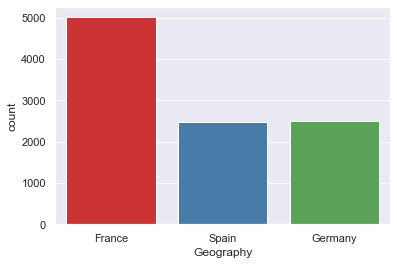

In [ ]:
# Negara asal nasabah
sns.countplot(x='Geography', data=df);

Nasabah paling banyak berasal dari France

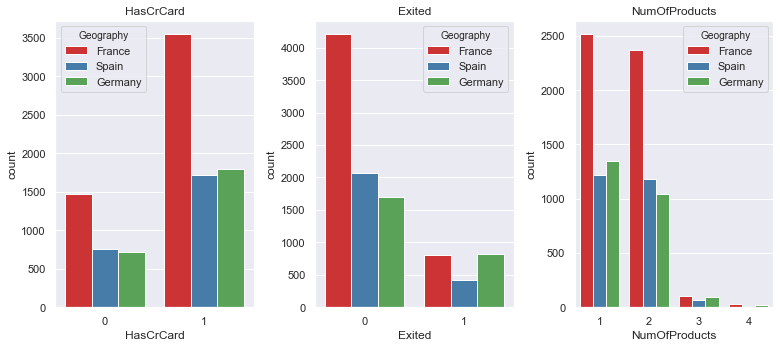

In [ ]:
# Jumlah nasabah untuk tiap categorical variables, dibagi berdasarkan asal negaranya
features = ['HasCrCard', 'Exited', 'NumOfProducts']
plt.figure(figsize=(11, 5))
sns.set(palette='Set1')
plotnumber = 1

for feature in features:
    ax = plt.subplot(1, 3, plotnumber)
    sns.countplot(x=feature, hue='Geography', data=df)
    plt.xlabel(feature)
    plt.title(feature)
    plotnumber += 1
    plt.tight_layout();

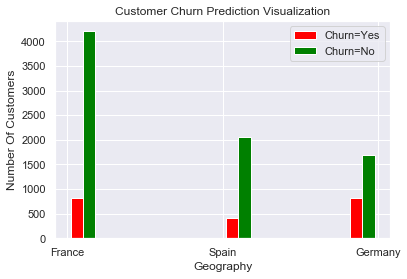

In [ ]:
# Perbandingan churn customers pada tiap negara
geo_churn_no = df[df.Exited==0]['Geography']
geo_churn_yes = df[df.Exited==1]['Geography']

plt.xlabel('Geography')
plt.ylabel('Number Of Customers')
plt.title('Customer Churn Prediction Visualization')
plt.hist([geo_churn_yes, geo_churn_no], color=['red', 'green'], label=['Churn=Yes', 'Churn=No'])
plt.legend();

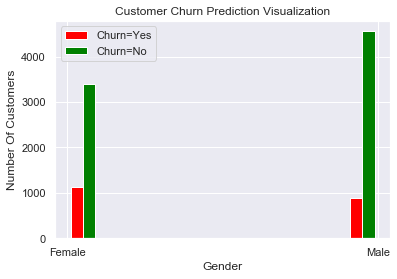

In [ ]:
# Perbandingan churn customers pada tiap gender

gender_churn_no = df[df.Exited==0]['Gender']
gender_churn_yes = df[df.Exited==1]['Gender']

plt.xlabel('Gender')
plt.ylabel('Number Of Customers')
plt.title('Customer Churn Prediction Visualization')
plt.hist([gender_churn_yes, gender_churn_no], color=['red', 'green'], label=['Churn=Yes', 'Churn=No'])
plt.legend();

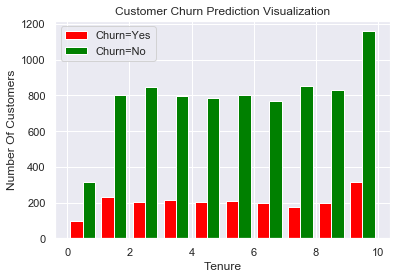

In [ ]:
# Perbandingan churn customers untuk tiap lama tahun Tenure/masa cicilan

tenure_churn_no = df[df.Exited==0].Tenure
tenure_churn_yes = df[df.Exited==1].Tenure

plt.xlabel('Tenure')
plt.ylabel('Number Of Customers')
plt.title('Customer Churn Prediction Visualization')
plt.hist([tenure_churn_yes, tenure_churn_no], color=['red', 'green'], label=['Churn=Yes', 'Churn=No'])
plt.legend();

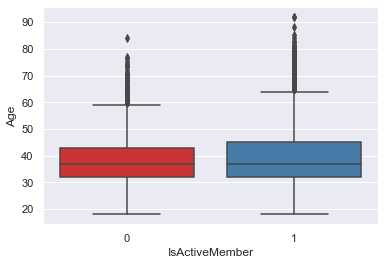

In [ ]:
# sebaran umur pada active member dan non-active member
sns.boxplot(x='IsActiveMember', y='Age', data=df);

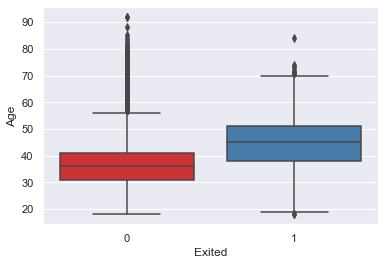

In [ ]:
# sebaran umur pada churn customer dan non-churn customer
sns.boxplot(x='Exited', y='Age', data=df);

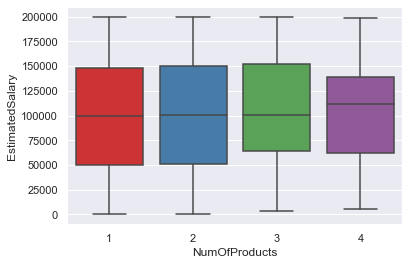

In [ ]:
# sebaran gaji pada tiap jumlah product yang digunakan oleh nasabah

sns.boxplot(x='NumOfProducts', y='EstimatedSalary', data=df);

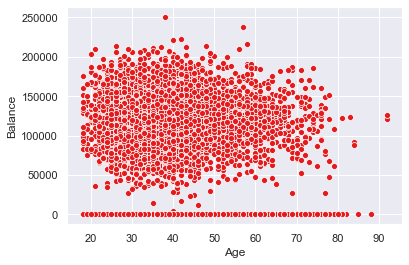

In [ ]:
# korelasi antara umur dan saldo
sns.scatterplot(x='Age', y='Balance', data=df);

## **Drop unnecessary features**

In [ ]:
# Drop some columns
df = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)
df

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


## **Data splitting**

In [ ]:
X = df.drop(['Exited'], axis=1)
y = df['Exited']

In [ ]:
# Split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    stratify=y,
    test_size=0.2,
    random_state=0
)

## **Data preprocessing**

In [ ]:
# Transformer scheme
transformer = ColumnTransformer([
    ('onehot', OneHotEncoder(), ['Geography', 'Gender'])
], remainder='passthrough')

## **Model benchmark**

In [ ]:
# DecsionTree
tree = DecisionTreeClassifier(random_state=0)

# RandomForest
rf = RandomForestClassifier(random_state=0)

# Adaboost
ada = AdaBoostClassifier(tree, random_state=0)

# Gradientboost
gbc = GradientBoostingClassifier(random_state=0)

# ExtremeGradientBosst
xgbc = XGBClassifier(random_state=0, verbosity=0)

In [ ]:
# Define imbalanced treatment method
models = [tree, rf, ada, gbc, xgbc]
score = []
nilai_mean = []
nilai_std = []

for i in models:

    smote = SMOTE(random_state=0)
    skfold = StratifiedKFold(n_splits=5)
    estimator = Pipeline([
        ('transformer', transformer),
        ('balancing', smote),
        ('model', i)
    ])

    model_cv = cross_val_score(
        estimator,
        X_train,
        y_train,
        cv=skfold,
        scoring='recall',
        error_score='raise'
        )

    print(model_cv, i)

    score.append(model_cv)
    nilai_mean.append(model_cv.mean())
    nilai_std.append(model_cv.std())

[0.47546012 0.5        0.5398773  0.55828221 0.47852761] DecisionTreeClassifier(random_state=0)
[0.45092025 0.51840491 0.50306748 0.51226994 0.46932515] RandomForestClassifier(random_state=0)
[0.48466258 0.50613497 0.52760736 0.56134969 0.50306748] AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=0),
                   random_state=0)
[0.51226994 0.52453988 0.57055215 0.54601227 0.51226994] GradientBoostingClassifier(random_state=0)
[0.49386503 0.51840491 0.52453988 0.53680982 0.5       ] XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=0, reg_alpha=None, 

In [ ]:
pd.DataFrame({
    'model':['tree', 'rf',' ada', 'gbc', 'xgbc'],
    'mean':nilai_mean,
    'std':nilai_std
})

,model,mean,std
0,tree,0.510429,0.033186
1,rf,0.490798,0.026173
2,ada,0.516564,0.026216
3,gbc,0.533129,0.022407
4,xgbc,0.514724,0.015809


Model GradientBoost dan XGBoost dipilih menjadi 2 model paling optimal karena memiliki nilai recall rata-rata paling tinggi.

- GradientBoost: 0.53


## **Model Performance on Test Set**

In [ ]:
models={
    'GradientBoosting': GradientBoostingClassifier(random_state=0),
    'XGBoost': XGBClassifier(random_state=0, verbosity=0)
}

score=[]

for i in models:

    model = Pipeline([
        ('transformer', transformer),
        ('balancing', smote),
        ('model', models[i])
    ])

    # fitting
    model.fit(X_train, y_train)

    # predict
    y_pred = model.predict(X_test)

    # recall score
    score.append([recall_score(y_test, y_pred)])

score_before_tuning = pd.DataFrame(score, columns=['Recall'], index = models.keys())
score_before_tuning


,Recall
GradientBoosting,0.503686
XGBoost,0.498771


In [ ]:
# model.get_params

## **Hyperparameter Tuning**

### Gradient Boost

In [ ]:
# kedalaman pohon
max_depth = list(np.arange(1,10))

# learning rate
learning_rate = list(np.arange(1,100)/100)

# jumlah pohon
n_estimators = list(np.arange(50,500))

# jumlah baris train set tiap pohon (% dari total baris train set)
subsample = list(np.arange(2,10)/10)

# jumlah feature yang digunakan untuk pertimbangan splitting (% dari total kolom train set)
max_features = list(np.arange(1,10)/10)

# Hyperparameter space GBC
hyperparam_space_gbc = {
    'balancing':[smote, None],
    'model__max_depth':max_depth ,
    'model__learning_rate':learning_rate,
    'model__n_estimators':n_estimators,
    'model__subsample':subsample,
    'model__max_features':max_features
}

In [ ]:
# Stratified cross validation
skf = StratifiedKFold(n_splits = 5)

# Balancing
smote = SMOTE()

# Benchmark model 1
gbc = GradientBoostingClassifier(random_state=0)

# Create the algorithm chains
estimator_gbc = Pipeline([
    ('tansformer', transformer),
    ('balancing', smote),
    ('model', gbc)
    ])

# Hyperparameter tuning
random_gbc = RandomizedSearchCV(
    estimator_gbc,
    param_distributions = hyperparam_space_gbc,
    cv = skf,
    scoring = 'recall',
    n_jobs = -1,
    random_state=0
)

In [ ]:
random_gbc.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('tansformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('onehot',
                                                                               OneHotEncoder(),
                                                                               ['Geography',
                                                                                'Gender'])])),
                                             ('balancing', SMOTE()),
                                             ('model',
                                              GradientBoostingClassifier(random_state=0))]),
                   n_jobs=-1,
                   param_distributions={'balancing'...
                                                                 0.21, 0.22,
              

In [ ]:
pd.DataFrame(random_gbc.cv_results_).sort_values(by='rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__subsample,param_model__n_estimators,param_model__max_features,param_model__max_depth,param_model__learning_rate,param_balancing,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
8,2.024799,0.027574,0.029199,0.007907,0.6,70,0.6,3,0.02,SMOTE(random_state=0),"{'model__subsample': 0.6, 'model__n_estimators...",0.515337,0.564417,0.592025,0.524540,0.539877,0.547239,0.027885,1
6,9.765001,0.085078,0.042600,0.000799,0.7,184,0.5,6,0.78,SMOTE(random_state=0),"{'model__subsample': 0.7, 'model__n_estimators...",0.549080,0.524540,0.530675,0.539877,0.512270,0.531288,0.012633,2
5,3.964601,0.017547,0.031601,0.000490,0.3,221,0.9,2,0.27,SMOTE(random_state=0),"{'model__subsample': 0.3, 'model__n_estimators...",0.475460,0.530675,0.555215,0.570552,0.521472,0.530675,0.032637,3
2,4.564599,0.046178,0.044201,0.000751,0.2,188,0.4,6,0.08,SMOTE(random_state=0),"{'model__subsample': 0.2, 'model__n_estimators...",0.512270,0.524540,0.576687,0.518405,0.506135,0.527607,0.025295,4
0,20.596400,0.233265,0.060197,0.001164,0.6,375,0.9,5,0.29,SMOTE(random_state=0),"{'model__subsample': 0.6, 'model__n_estimators...",0.509202,0.533742,0.530675,0.546012,0.503067,0.524540,0.015998,5


In [ ]:
print('GBC')
print('Best_score:', random_gbc.best_score_)
print('Best_params:', random_gbc.best_params_)


GBC
Best_score: 0.5472392638036809
Best_params: {'model__subsample': 0.6, 'model__n_estimators': 70, 'model__max_features': 0.6, 'model__max_depth': 3, 'model__learning_rate': 0.02, 'balancing': SMOTE(random_state=0)}


### XGBoost

In [ ]:
# kedalaman pohon
max_depth = list(np.arange(1,11))

# learning rate
learning_rate = list(np.arange(1,100)/100)

# jumlah pohon
n_estimators = list(np.arange(100,201))

# jumlah baris tiap pohon (% dari total baris train set)
subsample = list(np.arange(2,10)/10)

# gamma (min_impurity_decrease)
gamma = list(np.arange(1,11))

# jumlah feature yang digunakan untuk tiap pohon (% dari total kolom train set)
colsample_bytree = list(np.arange(1,10)/10)

# alpha (regularization)
reg_alpha = list(np.logspace(-3,1,10))


# Hyperparam space XGboost
hyperparam_space_xgbc = {
    'balancing':[smote, None],
    'model__max_depth':max_depth,
    'model__learning_rate':learning_rate,
    'model__n_estimators':n_estimators,
    'model__subsample':subsample,
    'model__gamma':gamma,
    'model__colsample_bytree':colsample_bytree,
    'model__reg_alpha': reg_alpha
}

In [ ]:
# Benchmark model 2
xgbc = XGBClassifier(random_state=0, verbosity=0)

# Create the algorithm chains
estimator_xgbc = Pipeline([
        ('tansformer', transformer),
        ('balancing', smote),
        ('model', xgbc)
        ])

# Hyperparameter tuning
random_xgbc = RandomizedSearchCV(
    estimator_xgbc,
    param_distributions = hyperparam_space_xgbc,
    cv = skf,
    scoring = 'recall',
    n_jobs = -1,
    random_state=0
)

In [ ]:
random_xgbc.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('tansformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('onehot',
                                                                               OneHotEncoder(),
                                                                               ['Geography',
                                                                                'Gender'])])),
                                             ('balancing', SMOTE()),
                                             ('model',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            colsample_bylevel=None,
                                  

In [ ]:
pd.DataFrame(random_xgbc.cv_results_).sort_values(by='rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__subsample,param_model__reg_alpha,param_model__n_estimators,param_model__max_depth,param_model__learning_rate,param_model__gamma,...,param_balancing,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
6,2.696998,0.096693,0.029597,0.001356,0.7,0.464159,180,1,0.34,9,...,SMOTE(),"{'model__subsample': 0.7, 'model__reg_alpha': ...",0.542945,0.552147,0.570552,0.549080,0.539877,0.550920,0.010732,1
5,2.585598,0.163814,0.029198,0.002484,0.5,0.0599484,195,1,0.35,7,...,SMOTE(),"{'model__subsample': 0.5, 'model__reg_alpha': ...",0.536810,0.549080,0.555215,0.533742,0.546012,0.544172,0.007904,2
3,5.103198,0.323655,0.032600,0.002867,0.5,0.0599484,142,5,0.18,6,...,SMOTE(),"{'model__subsample': 0.5, 'model__reg_alpha': ...",0.500000,0.533742,0.549080,0.546012,0.521472,0.530061,0.017928,3
1,2.356596,0.137912,0.033409,0.001963,0.9,0.0215443,105,3,0.85,10,...,SMOTE(),"{'model__subsample': 0.9, 'model__reg_alpha': ...",0.515337,0.518405,0.533742,0.536810,0.506135,0.522086,0.011543,4
7,3.981598,0.099883,0.029601,0.002060,0.9,0.0599484,111,7,0.75,10,...,None,"{'model__subsample': 0.9, 'model__reg_alpha': ...",0.487730,0.524540,0.533742,0.533742,0.487730,0.513497,0.021305,5


In [ ]:
print('XGBoost')
print('Best_score:', random_xgbc.best_score_)
print('Best_params:', random_xgbc.best_params_)

XGBoost
Best_score: 0.550920245398773
Best_params: {'model__subsample': 0.7, 'model__reg_alpha': 0.46415888336127775, 'model__n_estimators': 180, 'model__max_depth': 1, 'model__learning_rate': 0.34, 'model__gamma': 9, 'model__colsample_bytree': 0.8, 'balancing': SMOTE()}


## **Use the best estimator to predict test set**

In [ ]:
# best model
gbc_tuning = random_gbc.best_estimator_

# fitting
gbc_tuning.fit(X_train, y_train)

# predict
y_pred_gbc_tuning = gbc_tuning.predict(X_test)

# recall score
recall_gbc_tuning = recall_score(y_test, y_pred_gbc_tuning)
recall_gbc_tuning

0.5331695331695332

In [ ]:
# best model
xgbc_tuning = random_xgbc.best_estimator_

# fitting
xgbc_tuning.fit(X_train, y_train)

# predict
y_pred_xgbc_tuning = xgbc_tuning.predict(X_test)

# recall score
recall_xgbc_tuning = recall_score(y_test, y_pred_xgbc_tuning)
recall_xgbc_tuning

0.5036855036855037

In [ ]:
score_list = [recall_gbc_tuning, recall_xgbc_tuning]

models = ['GradientBoosting', 'XGBoost']

score_after_tuning = pd.DataFrame({
    'Model': models,
    'Recall': score_list
})

score_after_tuning

,Model,Recall
0,GradientBoosting,0.533170
1,XGBoost,0.503686


## **Recall score in Test Set**

In [ ]:
score_before_tuning

,Recall
GradientBoosting,0.503686
XGBoost,0.498771


In [ ]:
score_after_tuning

,Model,Recall
0,GradientBoosting,0.533170
1,XGBoost,0.503686


In [ ]:
print('GradientBoostingClassifier')
print(classification_report(y_test, y_pred_gbc_tuning))

GradientBoostingClassifier
              precision    recall  f1-score   support

           0       0.88      0.91      0.90      1593
           1       0.61      0.53      0.57       407

    accuracy                           0.84      2000
   macro avg       0.75      0.72      0.73      2000
weighted avg       0.83      0.84      0.83      2000



In [ ]:
print('XGBoost')
print(classification_report(y_test, y_pred_xgbc_tuning))

XGBoost
              precision    recall  f1-score   support

           0       0.88      0.93      0.90      1593
           1       0.64      0.50      0.56       407

    accuracy                           0.84      2000
   macro avg       0.76      0.72      0.73      2000
weighted avg       0.83      0.84      0.83      2000



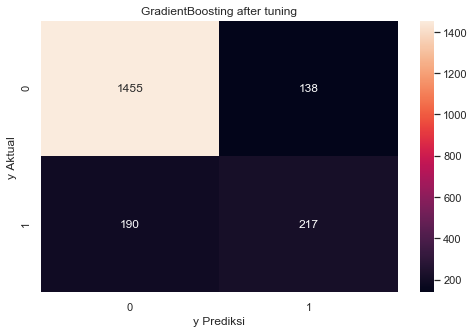

In [ ]:
# GradientBoost after tuning
f, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_gbc_tuning), annot=True, fmt='.0f', ax=ax)
plt.xlabel('y Prediksi')
plt.ylabel('y Aktual')
plt.title('GradientBoosting after tuning');

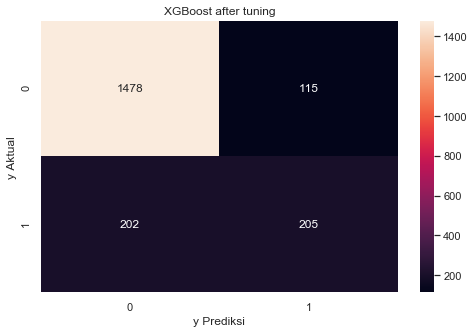

In [ ]:
# Model XGBoost after tuning

f, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_xgbc_tuning), annot=True, fmt='.0f', ax=ax)
plt.xlabel('y Prediksi')
plt.ylabel('y Aktual')
plt.title('XGBoost after tuning');

## **Summary**

Benchmark Model terbaik untuk dataset ini adalah Gradient Boost
- Recall val set  : 0.53
- Recall test set : 0.50

Dilakukan hyperparameter tuning
- Recall val set  : 0.54
- Recall test set : 0.53

Hyperparameter tuning berhasil menaikkan Recall dari model dengan Gradient Boost hanya sebesar 0.03.
Performa model sebesar 0.53 bisa dikatakan buruk karena jumlah False Negative hampir sama dengan jumlah True Positive.

Metric recall digunakan karena cost function dari False Negative dianggap lebih besar dari False Positif, sehingga jumlah False Negative yang dihasilkan oleh model harus diminimalkan.
Namun, karena jumlah kelas 1 hanya sekitar 20% dari jumlah data, menggunakan teknik resampling saja belum cukup untuk bisa menghasilkan model dengan performa optimal,
harus dicoba dengan melakukan pendekatan lain, misalnya dikombinasikan dengan feature engineering.


## **Latihan PCA & K-Means**


**Gunakan dataset Creditcard**

- Lakukan EDA untuk memahami dataset yang sedang dikerjakan.
- Lakukan data cleaning yang diperlukan dan lakukan scaling dengan Standardscaler.

- Lakukan PCA, lalu coba analisis antara jumlah komponen dan % informasi yang diekstraksi (variance explained).

- Untuk tujuan latihan kali ini, lakukan clustering dengan menggunakan 2 principal components, lalu cari jumlah cluster terbaik dengan elbow method dan silhouette score.
- Interpretasikan hasil clustering-nya.